## 1. Packages & Parallel Processing Setup

In [ ]:
# Packages and parallel setup
using Distributed
if nworkers() == 1
    addprocs(10) # adjust number of workers 
end
using Plots
using Colors
using ProgressMeter
@everywhere begin
    using Agents
    using Distributions
    using Random
end

## 2. Agent definition

In [2]:
@everywhere begin
    @agent struct Player(GridAgent{2})
        old_norm::Int64      # previous norm: 1 for norm1; 0 for norm2
        norm::Int64          # current norm: 1 for norm1; 0 for norm2
        groupID::Int         # 0 for Group A, 1 for Group B
        payoff::Float64
    end
end


## 3. Model initialization

In [ ]:
@everywhere begin
    function initialize(; # 
        M=30,
        init_norm1_groupA=0.6,
        init_norm1_groupB=0.4,
        norm1_prosocial_benefit=1.0,   # g
        norm1_coord_benefit=1.0,       # δ
        norm1_rarity_cost=1.0,         # h
        prob_outgroup_observation=0.0,
        symm=false,
    )
        space = GridSpaceSingle((M, M); periodic=false, metric=:manhattan)
        properties = Dict(
            :M => M,
            :init_norm1_groupA => init_norm1_groupA,
            :init_norm1_groupB => init_norm1_groupB,
            :norm1_prosocial_benefit => norm1_prosocial_benefit,
            :norm1_coord_benefit => norm1_coord_benefit,
            :norm1_rarity_cost => norm1_rarity_cost,
            :prob_outgroup_observation => prob_outgroup_observation,
            :symm => symm
        )
        model = StandardABM(Player, space;
            properties=properties,
            scheduler=Schedulers.Randomly(),
            (model_step!)=model_step!
        )


        half_x = div(M, 2) # how many times 2 fits into M without remainder
        for y in 1:M
            for x in 1:M
                group_id = (x <= half_x) ? 0 : 1 # 0 for Group A, 1 for Group B
                init_prob = (group_id == 0) ? init_norm1_groupA : init_norm1_groupB # initial probability of norm1 based on group
                s = rand() < init_prob ? 1 : 0 # assign norm based on initial probability
                add_agent_single!(model; old_norm=s, norm=s, groupID=group_id, payoff=0.0)
            end
        end
        return model
    end
end


## 4. Dynamics - model_step!

In [ ]:
@everywhere function model_step!(model)
    agents = collect(allagents(model))
    n = length(agents)

    if model.symm
        @inbounds for i in 1:n
            agents[i].old_norm = agents[i].norm # copy current norm to old_norm
        end
    end

    groupA_idx = Int[]
    groupB_idx = Int[]


    # Separate agents by group
    @inbounds for i in 1:n
        if agents[i].groupID == 0 # if in Group A
            push!(groupA_idx, i)
        else
            push!(groupB_idx, i)
        end
    end

    g = model.norm1_prosocial_benefit
    δ = model.norm1_coord_benefit
    h = model.norm1_rarity_cost

    # Group A
    if !isempty(groupA_idx)
        sA = 0.0
        @inbounds @simd for idx in groupA_idx # sum norms in Group A
            sA += agents[idx].norm
        end
        lenA = length(groupA_idx) # number of agents in Group A
        p1A = sA / lenA # proportion of norm1 in Group A

        norm1_payoffA = p1A * (1 + g + δ) + (1 - p1A) * (1 - h) # payoff for norm1 in Group A
        norm2_payoffA = p1A * (1 + g) + (1 - p1A)  # payoff for norm2 in Group A

        @inbounds for idx in groupA_idx # assign payoffs in Group A
            a = agents[idx]
            a.payoff = a.norm == 1 ? norm1_payoffA : norm2_payoffA
        end
    end

    # Group B
    if !isempty(groupB_idx)
        sB = 0.0
        @inbounds @simd for idx in groupB_idx
            sB += agents[idx].norm
        end
        lenB = length(groupB_idx)
        p1B = sB / lenB

        norm1_payoffB = p1B * (1 + g + δ) + (1 - p1B) * (1 - h)
        norm2_payoffB = p1B * (1 + g) + (1 - p1B)

        @inbounds for idx in groupB_idx
            a = agents[idx]
            a.payoff = a.norm == 1 ? norm1_payoffB : norm2_payoffB
        end
    end

    m = model.prob_outgroup_observation

    # Social learning
    for idx in randperm(n) # for each agent in random order
        a = agents[idx]
        my_group = a.groupID
        other_group = (rand() < m) ? (my_group + 1) % 2 : my_group # decide whether to observe in-group or out-group

        group_idxs = (other_group == 0) ? groupA_idx : groupB_idx # get indices of the chosen group
        if isempty(group_idxs)
            continue
        end

        if other_group == my_group && length(group_idxs) == 1 # only self in group
            continue
        end

        cand_idx = 0
        while true
            cand_idx = rand(group_idxs)
            if other_group != my_group || agents[cand_idx].id != a.id # ensure not self-observing
                break
            end
        end

        observed = agents[cand_idx] # observed agent
        payoff_diff = observed.payoff - a.payoff # payoff difference
        prob_copy = 1 / (1 + exp(-payoff_diff)) # probability of copying

        if rand() < prob_copy # decide to copy
            a.norm = model.symm ? observed.old_norm : observed.norm # copy norm - old_norm if symm, else current norm
        end
    end
end


## 5. Helper - running simulation batches

In [ ]:
@everywhere begin
    function run_trajectory(; # Run a single trajectory of the model
        M=30,
        init_norm1_groupA=0.8,
        init_norm1_groupB=0.15,
        norm1_prosocial_benefit=1.0,   # g
        norm1_coord_benefit=1.0,       # δ
        norm1_rarity_cost=0.5,         # h
        prob_outgroup_observation=0.0, # m
        symm=false,
        max_steps=500
    )
        model = initialize(
            M=M,
            init_norm1_groupA=init_norm1_groupA,
            init_norm1_groupB=init_norm1_groupB,
            norm1_prosocial_benefit=norm1_prosocial_benefit,
            norm1_coord_benefit=norm1_coord_benefit,
            norm1_rarity_cost=norm1_rarity_cost,
            prob_outgroup_observation=prob_outgroup_observation,
            symm=symm,
        )

        times = Int[]
        groupA_freq = Float64[]
        groupB_freq = Float64[]

        # t = 0
        push!(times, 0)
        groupA = filter(a -> a.groupID == 0, collect(allagents(model)))
        groupB = filter(a -> a.groupID == 1, collect(allagents(model)))
        push!(groupA_freq, mean(a -> a.norm, groupA))
        push!(groupB_freq, mean(a -> a.norm, groupB))

        step = 0
        while step < max_steps
            step!(model, 1)
            step += 1
            push!(times, step)
            groupA = filter(a -> a.groupID == 0, collect(allagents(model)))
            groupB = filter(a -> a.groupID == 1, collect(allagents(model)))
            push!(groupA_freq, mean(a -> a.norm, groupA))
            push!(groupB_freq, mean(a -> a.norm, groupB))
        end

        return (times, groupA_freq, groupB_freq) # return time series data
    end

    function run_trajectory_trials(; # Run multiple trajectories of the model
        n_trials=50,
        M=30,
        init_norm1_groupA=0.8,
        init_norm1_groupB=0.15,
        norm1_prosocial_benefit=1.0,
        norm1_coord_benefit=1.0,
        norm1_rarity_cost=0.5,
        prob_outgroup_observation=0.0,
        symm=false,
        max_steps=500
    )
        trajs = Vector{Tuple{Vector{Int},Vector{Float64},Vector{Float64}}}()
        for i in 1:n_trials
            traj = run_trajectory(
                M=M,
                init_norm1_groupA=init_norm1_groupA,
                init_norm1_groupB=init_norm1_groupB,
                norm1_prosocial_benefit=norm1_prosocial_benefit,
                norm1_coord_benefit=norm1_coord_benefit,
                norm1_rarity_cost=norm1_rarity_cost,
                prob_outgroup_observation=prob_outgroup_observation,
                symm=symm,
                max_steps=max_steps
            )
            push!(trajs, traj)
        end
        return trajs # return all trajectories
    end
end


## 7. Parameter sweep settings 

In [ ]:
# Set up parameter sweeps for Figures 7.10 and 7.11 - adjust parameters as needed

# Fig 7.10
h_vals = [0.25, 0.5, 0.75, 1.0] # - adjust as needed
m_range = 0.0:0.002:0.08    # - adjust as needed
n_trials_710 = 50 # - adjust as needed
max_steps_710 = 500 # - adjust as needed

# Fig 7.11
g_range = 0.0:0.5:6.0   # - adjust as needed
m_vals = [0.014, 0.016, 0.018] # - adjust as needed
n_trials_711 = 100 # - adjust as needed
max_steps_711 = 1000 # - adjust as needed

δ_val = 1.0  # - adjust as needed
M_val = 30  # - adjust as needed

# Fig 7.10
results_710 = Dict{Float64,Dict{Float64,Any}}()

# Fig 7.11
results_711 = Dict{Float64,Dict{Float64,Any}}()


param_cases = NamedTuple[]

# Fig 7.10
for h in h_vals, m in m_range
    push!(param_cases, (
        tag=:fig710,
        h=h,
        g=1.0, # - adjust as needed
        m=m,
        n_trials=n_trials_710,
        max_steps=max_steps_710,
    ))
end

# Fig 7.11
for m in m_vals, g in g_range
    push!(param_cases, (
        tag=:fig711,
        h=0.5,# - adjust as needed
        g=g,
        m=m,
        n_trials=n_trials_711,
        max_steps=max_steps_711,
    ))
end



## 8. Simulate




In [ ]:
# Run all parameter cases in parallel 

@info "Running combined sweep for Figures 7.10 and 7.11..."

progress_channel = RemoteChannel(() -> Channel{Int}(1000))
p = Progress(length(param_cases), dt=0.1, desc="Running trajectories")

@async begin
    for _ in progress_channel
        next!(p)
    end
end

results_tuples = pmap(param_cases) do pc
    trajs = run_trajectory_trials(
        n_trials=pc.n_trials,
        M=M_val,
        init_norm1_groupA=0.8, # initial norm1 frequency for Group A - adjust parameters as needed
        init_norm1_groupB=0.15, # initial norm1 frequency for Group B - adjust parameters as needed
        norm1_prosocial_benefit=pc.g,   # g
        norm1_coord_benefit=δ_val,  # δ
        norm1_rarity_cost=pc.h,   # h
        prob_outgroup_observation=pc.m, # m
        symm=false, # adjust as needed to switch between symmetric and symmetric updating
        max_steps=pc.max_steps
    )
    remotecall_fetch(() -> put!(progress_channel, 1), 1)
    return (pc.tag, pc.h, pc.g, pc.m, trajs)
end


close(progress_channel)


for (tag, h, g, m, trajs) in results_tuples
    if tag == :fig710
        inner = get!(results_710, h, Dict{Float64,Any}())
        inner[m] = trajs
    else
        inner = get!(results_711, m, Dict{Float64,Any}())
        inner[g] = trajs
    end
end


[ Info: Running combined sweep for Figures 7.10 and 7.11...
Running trajectories 100%|███████████████████████████████| Time: 0:02:06


## 9. Helper - build plots 



In [8]:

function plot_fig710(results_710, h_vals, m_range)
    plt = plot()
    palette = Plots.palette(:tab10, length(h_vals))

    for (i, h) in enumerate(h_vals)
        inner = results_710[h]

        m_all = Float64[]
        B_all = Float64[]

        for m in m_range
            trajs = inner[m]
            finals = [groupB[end] for (_, _, groupB) in trajs]
            append!(m_all, fill(m, length(finals)))
            append!(B_all, finals)
        end

        B_mean = [mean(B_all[m_all.==m]) for m in m_range]
        c = palette[i]


        scatter!(plt, m_all, B_all;
            alpha=0.25, ms=3, label="",
            markerstrokewidth=0, color=c)

        plot!(plt, m_range, B_mean;
            lw=3, label="h = $h", color=c)
    end

    xlabel!(plt, "prob outgroup observation, m")
    ylabel!(plt, "mean frequency of norm 1 in group B")
    return plt
end


plot_fig710 (generic function with 1 method)

In [13]:
function plot_fig711(results_711, m_vals, g_range)
    plt = plot()
    palette = Plots.palette(:tab10, length(m_vals))

    for (i, m) in enumerate(m_vals)
        inner = results_711[m]

        g_all = Float64[]
        B_all = Float64[]

        for g in g_range
            trajs = inner[g]
            finals = [groupB[end] for (_, _, groupB) in trajs]
            append!(g_all, fill(g, length(finals)))
            append!(B_all, finals)
        end

        B_mean = [mean(B_all[g_all.==g]) for g in g_range]
        c = palette[i]

        scatter!(plt, g_all, B_all;
            alpha=0.25, ms=3, label="",
            markerstrokewidth=0, color=c)

        plot!(plt, g_range, B_mean;
            lw=3, label="m = $m", color=c, legend=:right)
    end

    xlabel!(plt, "prosocial benefit, g")
    ylabel!(plt, "mean frequency of norm 1 in group B")
    return plt
end


plot_fig711 (generic function with 1 method)

## 10. Display plot



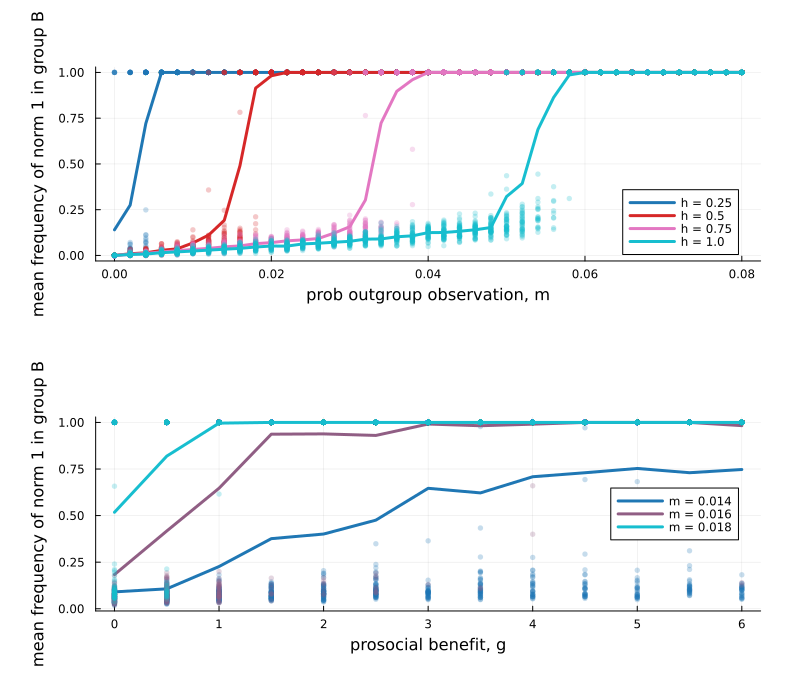

In [14]:
plt_710 = plot_fig710(results_710, h_vals, m_range)
plt_711 = plot_fig711(results_711, m_vals, g_range)

mm = Plots.mm
final_plt = plot(
    plt_710, plt_711;
    layout=(2, 1),
    size=(800, 700),
    left_margin=8mm,
    right_margin=8mm,
    bottom_margin=10mm,
    top_margin=15mm,
)

display(final_plt)
